# Bringing In The Dataset

In [188]:
import pandas as pd
import numpy as np
import sklearn
import json
import plotly.express as px
import warnings

In [40]:
foods_train_path = r"C:\Users\joe\Datasets\Foods_train.txt"
with open (foods_train_path, "r")  as data:
    json_data = data.read()
data = json.loads(json_data)
df = pd.DataFrame(data)

In [41]:
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


# EDA 1

In [42]:
# Dimensions of the dataset
df.shape

(39774, 3)

In [43]:
# Datatypes of the columns
df.dtypes

id              int64
cuisine        object
ingredients    object
dtype: object

In [44]:
print("Number of unique cuisines:", len(df["cuisine"].unique()))
df["cuisine"].unique()

Number of unique cuisines: 20


array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [45]:
# Checking for missing values
df.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

In [46]:
# Ingredients of first dish
df["ingredients"][0]

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

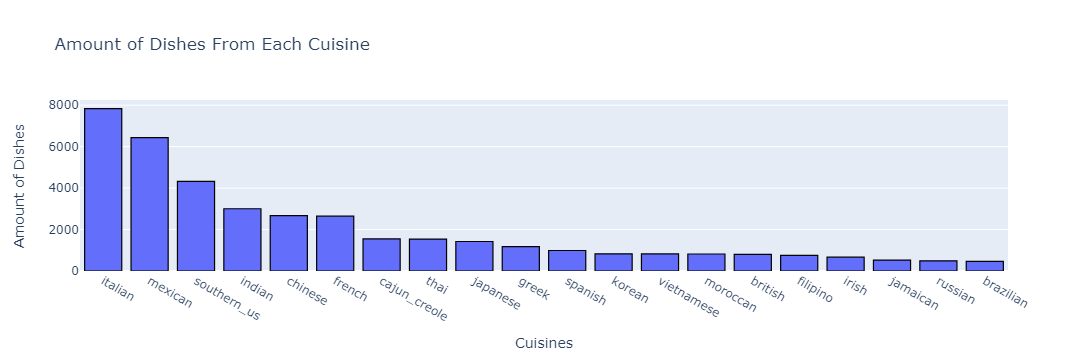

In [187]:
# Making a dataframe of the amount of dishes from each cuisine
dishes_count = pd.DataFrame(df.groupby("cuisine")["cuisine"].count().sort_values(ascending=False))

fig = px.histogram(dishes_count, x=dishes_count.index, y=dishes_count["cuisine"], title="Amount of Dishes From Each Cuisine",
                   labels={"index":"Cuisine"})
fig.for_each_trace(lambda t: t.update(hovertemplate=t.hovertemplate.replace("sum of cuisine", "Count"))) # To replace the title in the hover template
fig.update_traces(marker_line_width=1.2, marker_line_color="black")
fig.update_layout(xaxis_title="Cuisines", yaxis_title="Amount of Dishes")
fig

# Data Cleaning

For this project the id column will not be necessary, so I will drop it

In [48]:
df.drop("id", axis=1, inplace=True)
df.head()

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe..."


The main goal of this data cleaning is getting all the ingredients one-hot encoded to be able to train a model on them. 
The first step is to expand the ingredients column to get the ingredients out of the lists

In [89]:
expanded_df = pd.DataFrame(df["ingredients"].apply(pd.Series))
print("Dimensions of dataframe", expanded_df.shape)
expanded_df.head()

Dimensions of dataframe (39774, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,garbanzo beans,feta cheese crumbles,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,plain flour,ground pepper,salt,tomatoes,ground black pepper,thyme,eggs,green tomatoes,yellow corn meal,milk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,eggs,pepper,salt,mayonaise,cooking oil,green chilies,grilled chicken breasts,garlic powder,yellow onion,soy sauce,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,water,vegetable oil,wheat,salt,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,black pepper,shallots,cornflour,cayenne pepper,onions,garlic paste,milk,butter,salt,lemon juice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The next step is to apply one-hot encoding to the expanded dataframe

In [90]:
expanded_df = pd.get_dummies(expanded_df, prefix="", prefix_sep="")
print("Dimensions of dataframe", expanded_df.shape)

Dimensions of dataframe (39774, 43963)


There are a lot of duplicate ingredients in the one-hot encoded dataframe. This can be dealt with by grouping the columns 
based on sum because if a dish has a certain ingredient, a 1 will only show up in one of the duplicates. Before doing this, the
dataframe must be split smaller pieces to be more manageable

In [91]:
# Splitting the dataset
split_df_list = []
x = int(len(expanded_df.index) / 21)
for num in range(21):
    split_df = expanded_df.iloc[num*x : (num+1)*x, :]
    split_df_list.append(split_df)

Now the idea is to apply the grouping to each piece of the dataframe, then concatenate them to form a new dataframe with the 
same number of rows but less columns

In [95]:
# Grouping the ingredients for each dataframe in the list
for i in range(len(split_df_list)):
    split_df_list[i] = split_df_list[i].groupby(split_df_list[i].columns, axis=1).sum()   
# Concatenating the pieces
expanded_df = pd.concat(split_df_list, axis=0)

The last step is to add back the "cuisine" column

In [100]:
cuisine = pd.DataFrame(df["cuisine"])
expanded_df = pd.concat([cuisine, expanded_df], axis=1)
print("New Dimensions of dataframe:", expanded_df.shape)
expanded_df.head()

New Dimensions of dataframe: (39774, 6715)


,cuisine,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,greek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,southern_us,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,filipino,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are lots of very specific ingredients in the dataframe. It could be useful to take out ingredients that are not used
much. I will make a separate dataframe with only ingredients that are used 5 or more times

In [155]:
# Dropping the cuisine column for now, it will be added back later
expanded_df2 = expanded_df.drop("cuisine", axis=1)
expanded_df2 = expanded_df2.loc[:, expanded_df2.sum(axis=0) >=5]
expanded_df2 = pd.concat([cuisine, expanded_df2], axis=1) # Adding back cuisine column
expanded_df2.head()

,cuisine,( oz.) tomato sauce,( oz.) tomato paste,1% low-fat cottage cheese,1% low-fat milk,2% low-fat cottage cheese,2% reduced-fat milk,40% less sodium taco seasoning,40% less sodium taco seasoning mix,Accent Seasoning,...,yoghurt,yolk,yukon gold,yukon gold potatoes,yuzu,zest,zesty italian dressing,zinfandel,ziti,zucchini
0,greek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,southern_us,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,filipino,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# EDA 2

The dataframe is in the format I want. Now it's time to do more exploratory data analysis. Some questions to be answered are:
* Which cuisines use the most ingredients per dish on average?
* How many ingredients are used across a certain number of cuisines?
* For each cuisine, what are the most used ingredients?
* For a certain ingredient or group of ingredients, which cuisines use it the most?
* What are the most used ingredients overall?

### Cuisines With Most Ingredients Per Dish On Average

In [189]:
# Each row contains the cuisine and amount of ingredients for a dish
warnings.filterwarnings("ignore")
ingredients_count = pd.DataFrame(expanded_df.sum(axis=1))
ingredients_count_df = pd.concat([expanded_df["cuisine"], ingredients_count], axis=1)
ingredients_count_df.head()

,cuisine,0
0,greek,9
1,southern_us,11
2,filipino,12
3,indian,4
4,indian,20


In [190]:
# Statistical summary
ingredients_count_df.describe()

,0
count,39774.000000
mean,10.767713
std,4.428978
min,1.000000
25%,8.000000
50%,10.000000
75%,13.000000
max,65.000000


In [191]:
# Now groupby can be used to find the average count in each cuisine
ingredients_count_df.groupby("cuisine")[0].mean().sort_values(ascending=False).round(2)

cuisine
moroccan        12.91
indian          12.71
vietnamese      12.68
cajun_creole    12.62
thai            12.55
jamaican        12.21
chinese         11.98
korean          11.28
mexican         10.88
spanish         10.42
russian         10.22
greek           10.18
filipino        10.00
italian          9.91
french           9.82
japanese         9.74
british          9.71
southern_us      9.63
brazilian        9.52
irish            9.30
Name: 0, dtype: float64

This tells us the Moroccan, Indian, and Vietnamese cuisines use the most ingredients per dish on average

### Histogram For Amount Of Ingredients Per Dish

This is an extension of the previous topic, and ingredients_count_df can be used

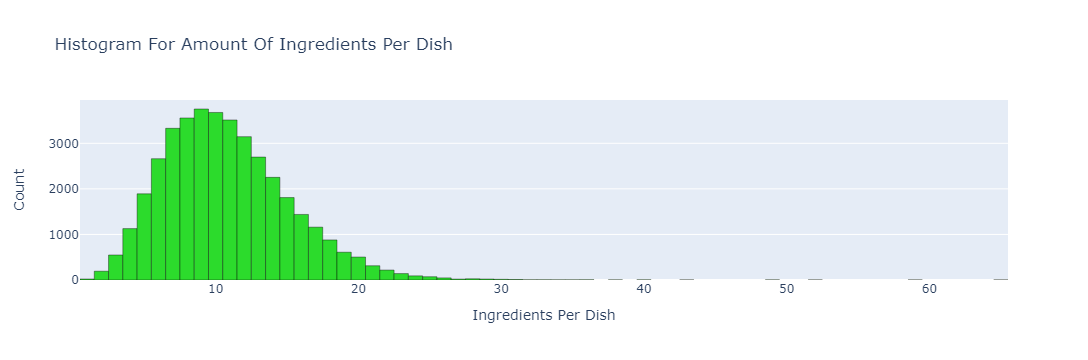

In [206]:
fig = px.histogram(ingredients_count_df, x=0, title="Histogram For Amount Of Ingredients Per Dish", labels={"0": "Ingredients"},
                   color_discrete_sequence=["#2cdb2c"])
fig.update_layout(xaxis_title="Ingredients Per Dish", yaxis_title="Count")
fig.update_traces(marker_line_width=0.4, marker_line_color="black")
fig

### Histogram For Ingredient Variety Across Cuisines

Each row in variety_df contains a cuisine and the amount of times each ingredient was used by it

In [202]:
ingredients = list(expanded_df.columns[1:])
variety_df = expanded_df.groupby("cuisine")[ingredients].sum().reset_index()
variety_df.head()

,cuisine,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,brazilian,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3,0
1,british,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,0,0,0,3,0
2,cajun_creole,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,13,0
3,chinese,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,30,0
4,filipino,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,6,0


Now the idea is to convert all the numbers in the dataset to True or False based on if they are greater than 0. Then summing
for each column will tell us how many different cuisines an ingredient was used across

In [203]:
variety_df = variety_df[ingredients] > 0
variety_df = pd.DataFrame(variety_df.sum(axis=0))
variety_df

,0
( oz.) tomato sauce,5
( oz.) tomato paste,3
(10 oz.) frozen chopped spinach,1
"(10 oz.) frozen chopped spinach, thawed and squeezed dry",2
(14 oz.) sweetened condensed milk,2
...,...
zesty italian dressing,4
zinfandel,4
ziti,2
zucchini,20


Now we have the format needed for the histogram

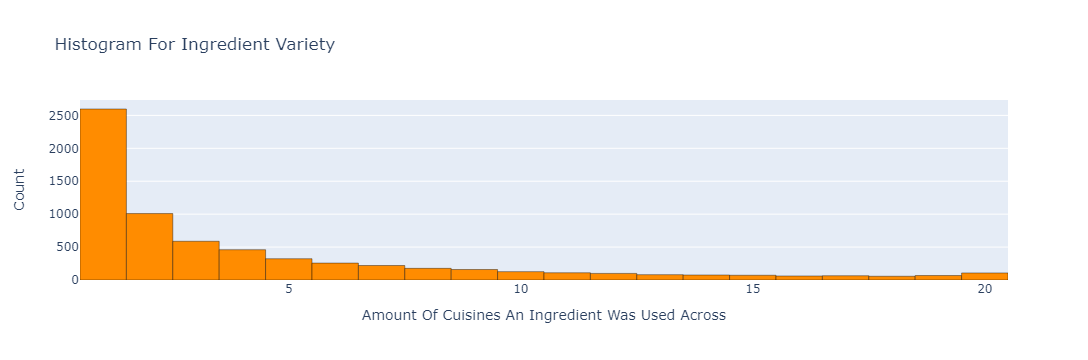

In [214]:
# Histogram
fig = px.histogram(variety_df, x=0, title="Histogram For Ingredient Variety", labels={"0":"Cuisines"}, 
                   color_discrete_sequence=["#ff8c00"])
fig.update_layout(xaxis_title="Amount Of Cuisines An Ingredient Was Used Across", yaxis_title="Count")
fig.update_traces(marker_line_width=0.4, marker_line_color="black")
fig

Lets see how this changes if expanded_df2 is used

In [211]:
# Same process as before
ingredients = list(expanded_df2.columns[1:])
variety_df2 = expanded_df2.groupby("cuisine")[ingredients].sum().reset_index()
variety_df2 = variety_df2[ingredients] > 0
variety_df2 = pd.DataFrame(variety_df2.sum(axis=0))

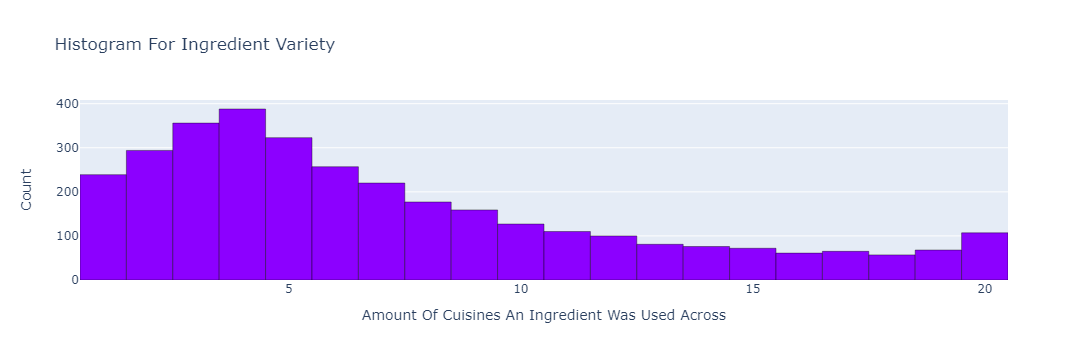

In [215]:
# Histogram
fig = px.histogram(variety_df2, x=0, title="Histogram For Ingredient Variety", labels={"0":"Cuisines"},
                   color_discrete_sequence=["#8c00ff"] )
fig.update_layout(xaxis_title="Amount Of Cuisines An Ingredient Was Used Across", yaxis_title="Count")
fig.update_traces(marker_line_width=0.4, marker_line_color="black")
fig

We can see that when only ingredients used 5 or more times are in the dataset, the variety is much more evenly spread out

### Most Used Ingredients In Each Cuisine

Here a function can be made that takes in a cuisine and number and returns the most used ingredients from that cuisine.
The number will be used to determine how long the list is

In [257]:
def cuisine_top_ingredients(cuisine, num):
    ingredients = list(expanded_df.columns[1:])
    cuisine_ingredients = expanded_df[expanded_df["cuisine"] == cuisine]
    cuisine_ingredients = cuisine_ingredients[ingredients].sum(axis=0) # How many times each ingredient is used
    top = list(np.argsort(cuisine_ingredients.values)[-num:]) # Returns indexes of greatest values
    top_ingredients = cuisine_ingredients[top].sort_values(ascending=False)
    return top_ingredients

In [264]:
# Calling the function
cuisine_top_ingredients("chinese", 15)

soy sauce        1363
sesame oil        915
salt              907
corn starch       906
sugar             824
garlic            763
water             762
green onions      628
vegetable oil     602
scallions         591
ginger            490
fresh ginger      469
rice vinegar      461
garlic cloves     421
oil               338
dtype: int64

In [269]:
# Another example
cuisine_top_ingredients("greek", 15)

salt                      572
olive oil                 504
dried oregano             267
garlic cloves             254
feta cheese crumbles      252
extra-virgin olive oil    229
fresh lemon juice         222
ground black pepper       221
garlic                    216
pepper                    203
feta cheese               191
cucumber                  187
purple onion              186
onions                    185
lemon juice               183
dtype: int64

### Most Common Cuisines For An Ingredient

Here a function can be made that takes in an ingredient or group of ingredients and returns a bar chart showing how many
times each cuisine used it

In [299]:
def ingredient_top_cuisines(ingredient_list):
    ingredient_list.append("cuisine") # So the cuisine column is inlcluded
    ingredient_df = expanded_df[ingredient_list]
    # Using sum to get dishes with all the ingredients. The -1 accounts for "cuisine" being in the list
    ingredient_df = ingredient_df[ingredient_df.iloc[:, 0:-1].sum(axis=1) == len(ingredient_list) - 1]
    ingredient_df = pd.DataFrame(ingredient_df.groupby("cuisine")["cuisine"].count().sort_values(ascending=False))
    # Making the bar chart based on ingredient_df
    fig = px.histogram(ingredient_df, x=ingredient_df.index, y="cuisine", title="Most Common Cuisines for Chosen Ingredients",
                       labels={"index":"Cuisine"}, color_discrete_sequence=["#00d8d8"])
    fig.update_layout(xaxis_title="Cuisines", yaxis_title="Amount of Dishes")
    fig.for_each_trace(lambda t: t.update(hovertemplate=t.hovertemplate.replace("sum of cuisine", "Count")))
    fig.update_traces(marker_line_width=1.2, marker_line_color="black")
    return fig

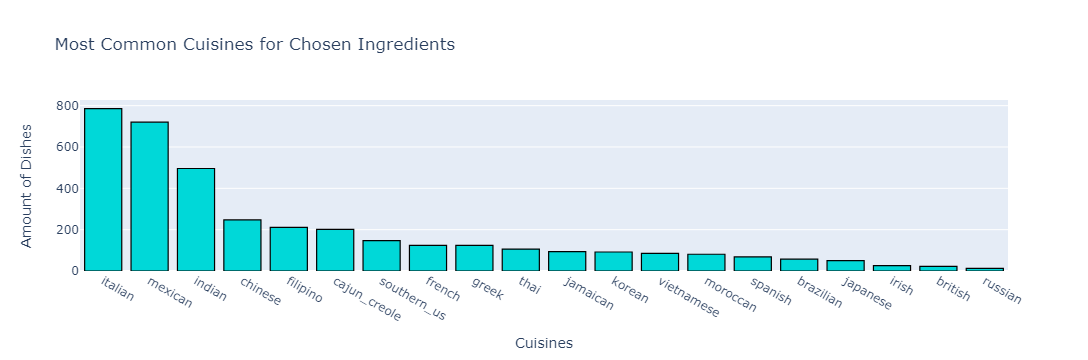

In [300]:
# Example 1
ingredient_top_cuisines(["garlic", "salt"])

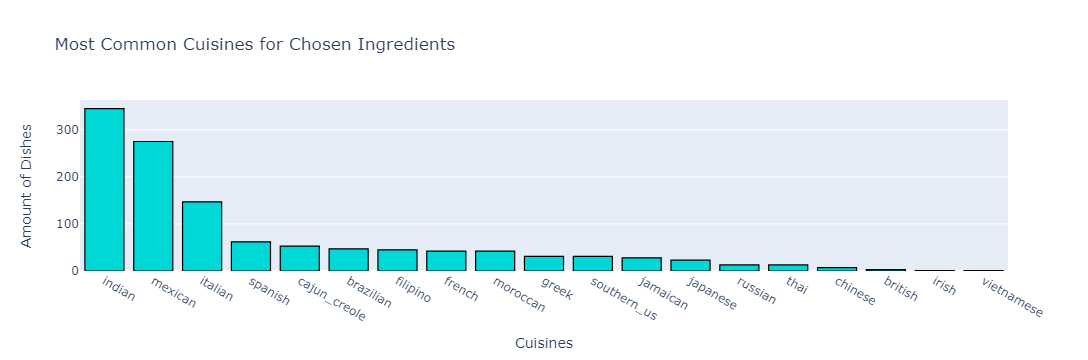

In [304]:
# Example 2
ingredient_top_cuisines(["onions", "tomatoes"])

### Most Used Ingredients Overall

In [313]:
# Summing to find how many times each ingredient was used
ingredients = list(expanded_df.columns[1:])
top_ingredients = expanded_df[ingredients].sum(axis=0)
top_ingredients

(    oz.) tomato sauce                                       11
(   oz.) tomato paste                                         9
(10 oz.) frozen chopped spinach                               3
(10 oz.) frozen chopped spinach, thawed and squeezed dry      2
(14 oz.) sweetened condensed milk                             2
                                                           ... 
zesty italian dressing                                       17
zinfandel                                                    10
ziti                                                         29
zucchini                                                    892
zucchini blossoms                                             2
Length: 6714, dtype: int64

In [318]:
# Top 20 most used ingredients
top_ingredients.sort_values(ascending=False)[0:20]

salt                   18049
olive oil               7972
onions                  7972
water                   7457
garlic                  7380
sugar                   6434
garlic cloves           6237
butter                  4848
ground black pepper     4785
all-purpose flour       4632
pepper                  4438
vegetable oil           4385
eggs                    3388
soy sauce               3296
kosher salt             3113
green onions            3078
tomatoes                3058
large eggs              2948
carrots                 2814
unsalted butter         2782
dtype: int64

# Training The Model

In [335]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [326]:
# Converting both expanded_df and expanded_df2 to numpy arrays
x = expanded_df.iloc[:, 1:].to_numpy()
x2 = expanded_df2.iloc[:, 1:].to_numpy()
y = expanded_df["cuisine"].to_numpy()
y2 = expanded_df2["cuisine"].to_numpy()

In [336]:
# Splitting into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.3, random_state=1)